In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

sys.path.append(f"{os.getcwd()}/../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import joblib
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from src.processing.utils import CleanUp, SNOWBALL_STEMMER, RSLP_STEMMER

%matplotlib inline

In [96]:
clean_up = CleanUp(remove_stopwords=True, stemmer=SNOWBALL_STEMMER)

In [97]:
df = pd.read_csv(f"{os.getcwd()}/../data/frases/dataset_emocoes.csv", sep="|")

In [98]:
X = df["Sentence"].apply(lambda comment: clean_up.fit(str(comment))).to_numpy()
y = np.argmax(pd.get_dummies(df["Emotion"]).to_numpy(), axis=-1)

In [99]:
emotions = {i: emotion for i, emotion in enumerate(pd.get_dummies(df["Emotion"]).columns)}
print(emotions)

{0: 'ALEGRIA', 1: 'DESGOSTO', 2: 'MEDO', 3: 'NEUTRO', 4: 'RAIVA', 5: 'SURPRESA', 6: 'TRISTEZA'}


In [100]:
print(f'Dataset size: {len(X)}')

Dataset size: 2496


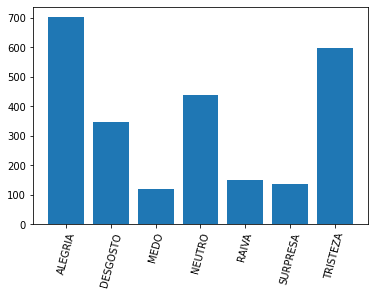

In [101]:
item, qtde = np.unique(y, return_counts=True)

plt.bar(item, qtde)
plt.xticks(range(7), list(emotions.values()), rotation=75)
plt.show()

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## LogisticRegression

Cross Validation accuracy: 0.54 (+/- 0.03)
[0.54666667 0.51893096 0.5545657  0.51893096 0.55233853]
--------------------
Classification Report
--------------------
              precision    recall  f1-score   support

           0       0.51      0.78      0.62        83
           1       0.57      0.24      0.33        34
           2       0.00      0.00      0.00        11
           3       0.84      0.86      0.85        37
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00        16
           6       0.54      0.63      0.58        60

    accuracy                           0.57       250
   macro avg       0.35      0.36      0.34       250
weighted avg       0.50      0.57      0.52       250

Confusion Matrix
--------------------


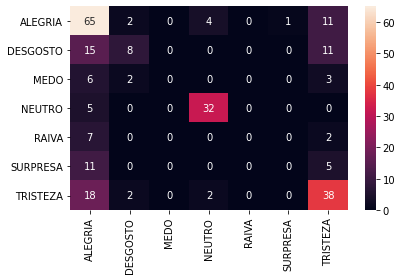

In [103]:
pipe = Pipeline(steps=[("tfidf", TfidfVectorizer(lowercase=False)), ("lr", LogisticRegression())])
pipe.fit(X_train, y_train)
scores = cross_val_score(pipe, X_train, y_train, cv=5)
print(
    "Cross Validation accuracy: %0.2f (+/- %0.2f)"
    % (scores.mean(), scores.std() * 2)
)
print(scores)
print("-" * 20)

# Predict the test data and show others metrics
pred = pipe.predict(X_test)
print("Classification Report")
print("-" * 20)
print(classification_report(y_test, pred))
print("Confusion Matrix")
print("-" * 20)
df_cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d", xticklabels=list(emotions.values()), yticklabels=list(emotions.values()))
plt.tight_layout()
plt.show()

Cross Validation accuracy: 0.54 (+/- 0.04)
[0.56888889 0.51224944 0.54120267 0.51002227 0.54565702]
--------------------
Classification Report
--------------------
              precision    recall  f1-score   support

           0       0.54      0.82      0.65        83
           1       0.38      0.38      0.38        34
           2       0.00      0.00      0.00        11
           3       0.97      0.84      0.90        37
           4       0.00      0.00      0.00         9
           5       0.33      0.06      0.11        16
           6       0.62      0.55      0.58        60

    accuracy                           0.58       250
   macro avg       0.41      0.38      0.37       250
weighted avg       0.54      0.58      0.55       250

Confusion Matrix
--------------------


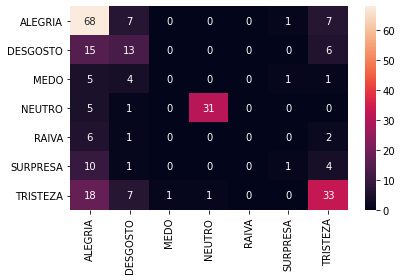

In [104]:
pipe = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(lowercase=False)),
    ("lr", SVC(class_weight='balanced', probability=True))
])
pipe.fit(X_train, y_train)
scores = cross_val_score(pipe, X_train, y_train, cv=5)
print(
    "Cross Validation accuracy: %0.2f (+/- %0.2f)"
    % (scores.mean(), scores.std() * 2)
)
print(scores)
print("-" * 20)

# Predict the test data and show others metrics
pred = pipe.predict(X_test)
print("Classification Report")
print("-" * 20)
print(classification_report(y_test, pred))
print("Confusion Matrix")
print("-" * 20)
df_cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d", xticklabels=list(emotions.values()), yticklabels=list(emotions.values()))
plt.tight_layout()
plt.show()

## Support Vector Machines Classifier

In [9]:
parameters = {
    "tfidf__ngram_range": [(1, 1), (2, 2), (3, 3), (1, 2), (1, 3), (1, 4), (1, 5)],
    "svm__kernel": ["linear", "rbf"],
    "svm__C": [1, 5, 7, 9, 15],
    "svm__random_state": [0, 10, 100, 1000],
}
pipe = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(lowercase=False)),
    ("lr", SVC(class_weight='balanced', probability=True))
])
pipe = GridSearchCV(pipe, parameters, n_jobs=-1)

In [11]:
# Fit the dataset to pipeline
pipe.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % pipe.best_score_)
print(pipe.best_params_)

Best parameter (CV score=0.544):
{'svm__C': 1, 'svm__kernel': 'linear', 'svm__random_state': 0, 'tfidf__ngram_range': (1, 4)}


Validating TF-IDF + SVM
Cross Validation accuracy: 0.54 (+/- 0.02)
[0.565      0.53634085 0.54135338 0.52882206 0.54887218]
--------------------
Classification Report
--------------------
              precision    recall  f1-score   support

           0       0.51      0.79      0.62       155
           1       0.42      0.21      0.28        63
           2       1.00      0.04      0.07        26
           3       0.90      0.86      0.88        87
           4       0.33      0.03      0.06        29
           5       0.00      0.00      0.00        24
           6       0.49      0.60      0.54       116

    accuracy                           0.56       500
   macro avg       0.52      0.36      0.35       500
weighted avg       0.55      0.56      0.51       500

Confusion Matrix
--------------------


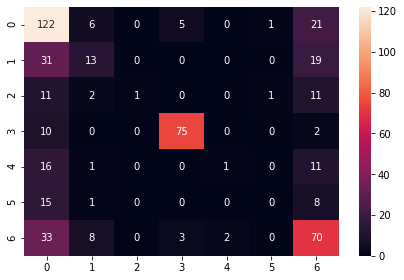

In [12]:
# Best params for each step of pipeline
tfidf_params = pipe.best_estimator_.named_steps["tfidf"].get_params()
svm_params = pipe.best_estimator_.named_steps["svm"].get_params()

# After run GridSearchCV
print("Validating TF-IDF + SVM")
pipe = make_pipeline(TfidfVectorizer(**tfidf_params), SVC(**svm_params))

# Verify cross validation ... above 0.75 is good enough
scores = cross_val_score(pipe, X_train, y_train, cv=5)
print(
    "Cross Validation accuracy: %0.2f (+/- %0.2f)"
    % (scores.mean(), scores.std() * 2)
)
print(scores)
print("-" * 20)

# Predict the test data and show others metrics
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print("Classification Report")
print("-" * 20)
print(classification_report(y_test, pred))
print("Confusion Matrix")
print("-" * 20)
df_cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d", xticklabels=list(emotions.values()), yticklabels=list(emotions.values()))
plt.tight_layout()
plt.show()

In [17]:
# Rebuild the classifier, build a new pipeline (equal as above), fit and save the model
pipe = make_pipeline(TfidfVectorizer(**tfidf_params), SVC(**svm_params))
pipe.fit(X, y)
joblib.dump(pipe, f"{os.getcwd()}/../models/emotion_classifier.model")

['/ssd/programas/sentiment-text-prediction-api/notebooks/../models/emotion_classifier.model']